## 1. Import

In [1]:
import pandas as pd
import numpy as np

import re
import string
from urllib.parse import urlparse

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

import warnings
warnings.filterwarnings(action='ignore')

## 2. Data Load

In [2]:
# 학습/평가 데이터 로드
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# '[.]'을 '.'으로 복구
train_df['URL'] = train_df['URL'].str.replace(r'\[\.\]', '.', regex=True)
test_df['URL'] = test_df['URL'].str.replace(r'\[\.\]', '.', regex=True)

In [3]:
train_df.isnull().sum()

ID       0
URL      0
label    0
dtype: int64

In [4]:
train_df['label'].value_counts()

label
0    5430159
1    1564897
Name: count, dtype: int64

## 3. Feature-Engineering (FE)

In [5]:
## 새로운 변수 생성
# URL 길이
train_df['length'] = train_df['URL'].str.len()
test_df['length'] = test_df['URL'].str.len()

# 서브도메인 개수
train_df['subdomain_count'] = train_df['URL'].str.split('.').apply(lambda x: len(x) - 2)
test_df['subdomain_count'] = test_df['URL'].str.split('.').apply(lambda x: len(x) - 2)

# 특수 문자 개수
train_df['special_char_count'] = train_df['URL'].apply(lambda x: sum(1 for c in x if c in string.punctuation))
test_df['special_char_count'] = test_df['URL'].apply(lambda x: sum(1 for c in x if c in string.punctuation))

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,2,3
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,2,3
2,TRAIN_0000002,nationalfinance.co.om,0,21,1,2
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,2,3
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5


In [6]:
# 문자 개수
# def count_letters(url):
#     num_letters = sum(char.isalpha() for char in url)
#     return num_letters


# 숫자 개수
def count_digits(url):
    num_digits = sum(char.isdigit() for char in url)
    return num_digits


# train_df["num_letters"] = train_df["URL"].apply(count_letters)
# test_df["num_letters"] = test_df["URL"].apply(count_letters)
train_df["num_digits"] = train_df["URL"].apply(count_digits)
test_df["num_digits"] = test_df["URL"].apply(count_digits)

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_digits
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,2,3,0
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,2,3,0
2,TRAIN_0000002,nationalfinance.co.om,0,21,1,2,0
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,2,3,0
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,2


In [7]:
# # 짧은 링크인지 여부
# def has_shortening_service(url):
#     pattern = re.compile(r'(?:\w+\.)*(\w+)\.\w+')
#     match = pattern.search(url)
    
#     if match:
#         domain = match.group(1)
#         common_shortening_services = ['bit', 'goo', 'tinyurl', 'ow', 't', 'is',
#                                       'cli', 'yfrog', 'migre', 'ff', 'url4', 'twit',
#                                       'su', 'snipurl', 'short', 'BudURL', 'ping', 
#                                       'post', 'Just', 'bkite', 'snipr', 'fic', 
#                                       'loopt', 'doiop', 'kl', 'wp', 
#                                       'rubyurl', 'om', 'to', 'lnkd', 
#                                       'db', 'adf', 'bitly', 'cur', 'ity', 'q', 
#                                       'po', 'bc', 'twitthis', 'j', 'buzurl', 
#                                       'cutt', 'u', 'yourls', 'x', 'prettylinkpro', 
#                                       'scrnch', 'filoops', 'vzturl', 'qr', '1url', 
#                                       'tweez', 'v', 'tr', 'link', 'zip']
        
#         if domain.lower() in common_shortening_services:
#             return 1
#     return 0

# train_df["shortened"] = train_df["URL"].apply(has_shortening_service)
# test_df["shortened"] = test_df["URL"].apply(has_shortening_service)

# train_df.head()

In [8]:
# # URL에 https 포함 여부
# def include_https(url):
#     if "https" in url:
#         return 1
#     return 0

# train_df["https"] = train_df["URL"].apply(include_https)
# test_df["https"] = test_df["URL"].apply(include_https)

# train_df.head()

In [9]:
# 대문자 포함 여부
def include_uppercase(url):
    if any(x.isupper() for x in url):
        return 1
    return 0

train_df["uppercase"] = train_df["URL"].apply(include_uppercase)
test_df["uppercase"] = test_df["URL"].apply(include_uppercase)

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_digits,uppercase
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,2,3,0,0
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,2,3,0,0
2,TRAIN_0000002,nationalfinance.co.om,0,21,1,2,0,0
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,2,3,0,0
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,2,1


In [10]:
# # URL에 IP 주소 포함 여부
# def include_ip_address(url):
#     pattern = re.compile(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}')
#     match = pattern.search(url)
    
#     if match:
#         return 1
#     return 0

# train_df["ip_address"] = train_df["URL"].apply(include_ip_address)
# test_df["ip_address"] = test_df["URL"].apply(include_ip_address)

# train_df.head()

In [14]:
# # 파일확장자 포함 여부
# def check_extension(url):
#     extensions = [
#         ".php",
#         ".html",
#         ".htm",
#         ".hwp",
#         ".hwpx",
#         ".pptx",
#         ".docx",
#         ".iso",
#         ".js",
#         ".lnk",
#         ".vbs",
#         ".xls",
#         ".xml",
#         ".zip",
#         ".xlsx",
#     ]
#     for ext in extensions:
#         if ext in url:
#             return 1
#     return 0


# train_df["extension_check"] = train_df["URL"].apply(lambda url: check_extension(url))
# test_df["extension_check"] = test_df["URL"].apply(lambda url: check_extension(url))

# train_df.head()

In [15]:
# URL 무작위성
import math
from collections import Counter


def calculate_entropy(url):
    # 문자 빈도수 계산
    counter = Counter(url)
    length = len(url)

    # 섀넌 엔트로피 계산
    entropy = 0
    for count in counter.values():
        probability = count / length
        entropy -= probability * math.log2(probability)
    return entropy


def check_randomness(url):
    # 1. 엔트로피 계산
    entropy = calculate_entropy(url)

    # 2. 연속된 숫자나 문자의 최대 길이
    max_consecutive = 1
    current_consecutive = 1
    for i in range(1, len(url)):
        if (
            url[i].isalnum()
            and url[i - 1].isalnum()
            and url[i].lower() == url[i - 1].lower()
        ):
            current_consecutive += 1
            max_consecutive = max(max_consecutive, current_consecutive)
        else:
            current_consecutive = 1

    # 3. 숫자와 문자의 교차 패턴 수
    transitions = 0
    for i in range(1, len(url)):
        if (url[i - 1].isdigit() and url[i].isalpha()) or (
            url[i - 1].isalpha() and url[i].isdigit()
        ):
            transitions += 1

    # 무작위성 점수 계산 (0~1 사이로 정규화)
    entropy_score = min(entropy / 5.0, 1.0)  # 일반적인 URL의 최대 엔트로피를 5로 가정
    consecutive_score = min(
        max_consecutive / 10.0, 1.0
    )  # 연속된 문자가 많을수록 낮은 점수
    transition_score = min(transitions / 10.0, 1.0)  # 전환이 많을수록 높은 점수

    # 종합 점수 계산 (가중치 조정 가능)
    randomness_score = (
        entropy_score * 0.5 + (1 - consecutive_score) * 0.3 + transition_score * 0.2
    )

    return randomness_score


# 데이터프레임에 적용
train_df["randomness"] = train_df["URL"].apply(check_randomness)
test_df["randomness"] = test_df["URL"].apply(check_randomness)

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_digits,uppercase,randomness
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,2,3,0,0,0.600827
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,2,3,0,0,0.587135
2,TRAIN_0000002,nationalfinance.co.om,0,21,1,2,0,0,0.597280
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,2,3,0,0,0.593377
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,2,1,0.667245


In [16]:
# 타이포스쿼팅 구분
def check_typosquatting(url):
    # 자주 사용되는 브랜드/도메인 목록
    common_brands = {
        "google",
        "facebook",
        "amazon",
        "microsoft",
        "apple",
        "netflix",
        "paypal",
        "twitter",
        "instagram",
        "linkedin",
        "youtube",
        "yahoo",
        "gmail",
        "whatsapp",
        "tiktok",
        "geocities",
        "angelfire",
        "newadvent",
        "wikipedia",
    }

    # 타이포스쿼팅 패턴 점수
    score = 0

    try:
        # URL 파싱
        parsed = urlparse(url if "//" in url else "//" + url)
        domain = parsed.netloc.lower() if parsed.netloc else url.lower()

        # 1. 숫자로 문자 대체 패턴 (예: o -> 0, i -> 1, e -> 3)
        number_substitutions = sum(1 for c in domain if c.isdigit())
        if number_substitutions > 0:
            score += 0.2

        # 2. 유사 브랜드 확인
        for brand in common_brands:
            # 레벤슈타인 거리 계산 (문자열 간 편집 거리)
            if brand not in domain:
                similar = False
                # 비슷한 철자 패턴 확인
                patterns = [
                    brand.replace("o", "0"),
                    brand.replace("i", "1"),
                    brand.replace("l", "1"),
                    brand.replace("e", "3"),
                    brand.replace("a", "4"),
                    brand.replace("s", "5"),
                    brand + "-",
                    brand + "_",
                    brand[:-1],  # 마지막 문자 제거
                    "".join(c + c for c in brand),  # 문자 중복
                ]

                for pattern in patterns:
                    if pattern in domain:
                        similar = True
                        break

                if similar:
                    score += 0.3
                    break

        # 3. 반복되는 문자 패턴
        repeated_chars = re.findall(r"(.)\1{2,}", domain)
        if repeated_chars:
            score += 0.2

        # 4. 특수문자 사용
        special_chars = re.findall(r"[-_.]", domain)
        if len(special_chars) > 2:  # 도메인에 특수문자가 많이 사용된 경우
            score += 0.2

        # 5. 도메인 길이 확인
        if len(domain) > 30:  # 비정상적으로 긴 도메인
            score += 0.1

    except:
        return 0

    return min(score, 1.0)  # 최대 점수는 1.0


# 데이터프레임에 적용
train_df["typosquatting"] = train_df["URL"].apply(check_typosquatting)
test_df["typosquatting"] = test_df["URL"].apply(check_typosquatting)

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_digits,uppercase,randomness,typosquatting
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,2,3,0,0,0.600827,0.2
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,2,3,0,0,0.587135,0.2
2,TRAIN_0000002,nationalfinance.co.om,0,21,1,2,0,0,0.597280,0.0
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,2,3,0,0,0.593377,0.2
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,2,1,0.667245,0.4


In [17]:
# 피싱 키워드 포함 여부
def include_fishing_keyword(url):
    keywords = [
        "signin", "login", "account", "update", "reset", "urgent", "alert", 
        "security", "support", "banking", "secure", "verify", "password",
        "payment", "customer", "service", "confirm", "approve", "activate",
        "activation", "member", "center", "info", "identity", "register",
        "validation", "authenticate", "recovery", "unblock", "resolution",
        "unlock", "verification", "bank", "transfer", "card",
        "free", "event", "prize"
    ]
    
    url_lower = url.lower()
    for keyword in keywords:
        if keyword in url_lower:
            return 1
    return 0

train_df["fishing_keyword"] = train_df["URL"].apply(include_fishing_keyword)
test_df["fishing_keyword"] = test_df["URL"].apply(include_fishing_keyword)

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_digits,uppercase,randomness,typosquatting,fishing_keyword
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,2,3,0,0,0.600827,0.2,0
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,2,3,0,0,0.587135,0.2,0
2,TRAIN_0000002,nationalfinance.co.om,0,21,1,2,0,0,0.597280,0.0,0
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,2,3,0,0,0.593377,0.2,0
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,2,1,0.667245,0.4,1


In [18]:
# URL 구성 요소 파싱
def parse_url_components(url):
    try:
        if not url.startswith('http://') and not url.startswith('https://'):
            url = 'http://' + url
            
        parsed = urlparse(url)
        domain = parsed.netloc
        domain_parts = domain.split('.')
        
        components = {
            'domain': domain,
            'path': parsed.path if parsed.path else '',
            'params': parsed.params if parsed.params else '',
            'query': parsed.query if parsed.query else '',
            'fragment': parsed.fragment if parsed.fragment else '',
            'tld': domain_parts[-1] if domain_parts else '',
            'sld': domain_parts[-2] if len(domain_parts) > 1 else '',
            'subdomain': '.'.join(domain_parts[:-2]) if len(domain_parts) > 2 else ''
        }
        
        return components
        
    except:
        return {
            'domain': '', 'path': '', 'params': '',
            'query': '', 'fragment': '', 'tld': '',
            'sld': '', 'subdomain': ''
        }

for df in [train_df, test_df]:
    components = df['URL'].apply(parse_url_components)
    
    df['url_path'] = components.apply(lambda x: x['path'])
    # df['url_params'] = components.apply(lambda x: x['params'])
    # df['url_query'] = components.apply(lambda x: x['query'])
    # df['url_fragment'] = components.apply(lambda x: x['fragment'])
    df['url_tld'] = components.apply(lambda x: x['tld'])
    df['url_sld'] = components.apply(lambda x: x['sld'])
    df['url_subdomain'] = components.apply(lambda x: x['subdomain'])

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_digits,uppercase,randomness,typosquatting,fishing_keyword,url_path,url_tld,url_sld,url_subdomain
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,2,3,0,0,0.600827,0.2,0,,pl,gov,poznan.wuoz
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,2,3,0,0,0.587135,0.2,0,,jp,kochi,vill.okawa
2,TRAIN_0000002,nationalfinance.co.om,0,21,1,2,0,0,0.597280,0.0,0,,om,co,nationalfinance
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,2,3,0,0,0.593377,0.2,0,,jp,hokkaido,town.ozora
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,2,1,0.667245,0.4,1,/online/Login,irish,ie-news,open24


In [19]:
# URL 구성 요소들의 길이
train_df['url_path_length'] = train_df['url_path'].str.len()
train_df['url_tld_length'] = train_df['url_tld'].str.len()
train_df['url_sld_length'] = train_df['url_sld'].str.len()
train_df['url_subdomain_length'] = train_df['url_subdomain'].str.len()

test_df['url_path_length'] = test_df['url_path'].str.len()
test_df['url_tld_length'] = test_df['url_tld'].str.len()
test_df['url_sld_length'] = test_df['url_sld'].str.len()
test_df['url_subdomain_length'] = test_df['url_subdomain'].str.len()

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_digits,uppercase,randomness,typosquatting,fishing_keyword,url_path,url_tld,url_sld,url_subdomain,url_path_length,url_tld_length,url_sld_length,url_subdomain_length
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,2,3,0,0,0.600827,0.2,0,,pl,gov,poznan.wuoz,0,2,3,11
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,2,3,0,0,0.587135,0.2,0,,jp,kochi,vill.okawa,0,2,5,10
2,TRAIN_0000002,nationalfinance.co.om,0,21,1,2,0,0,0.597280,0.0,0,,om,co,nationalfinance,0,2,2,15
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,2,3,0,0,0.593377,0.2,0,,jp,hokkaido,town.ozora,0,2,8,10
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,2,1,0.667245,0.4,1,/online/Login,irish,ie-news,open24,13,5,7,6


In [20]:
# URL 구성 요소들의 특수문자 개수
train_df['url_path_special_chars'] = train_df['url_path'].apply(lambda x: sum(1 for c in x if c in string.punctuation))
# train_df['url_tld_special_chars'] = train_df['url_tld'].apply(lambda x: sum(1 for c in x if c in string.punctuation))
train_df['url_sld_special_chars'] = train_df['url_sld'].apply(lambda x: sum(1 for c in x if c in string.punctuation))
# train_df['url_subdomain_special_chars'] = train_df['url_subdomain'].apply(lambda x: sum(1 for c in x if c in string.punctuation))

test_df['url_path_special_chars'] = test_df['url_path'].apply(lambda x: sum(1 for c in x if c in string.punctuation))
# test_df['url_tld_special_chars'] = test_df['url_tld'].apply(lambda x: sum(1 for c in x if c in string.punctuation))
test_df['url_sld_special_chars'] = test_df['url_sld'].apply(lambda x: sum(1 for c in x if c in string.punctuation))
# test_df['url_subdomain_special_chars'] = test_df['url_subdomain'].apply(lambda x: sum(1 for c in x if c in string.punctuation))

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_digits,uppercase,randomness,typosquatting,...,url_path,url_tld,url_sld,url_subdomain,url_path_length,url_tld_length,url_sld_length,url_subdomain_length,url_path_special_chars,url_sld_special_chars
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,2,3,0,0,0.600827,0.2,...,,pl,gov,poznan.wuoz,0,2,3,11,0,0
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,2,3,0,0,0.587135,0.2,...,,jp,kochi,vill.okawa,0,2,5,10,0,0
2,TRAIN_0000002,nationalfinance.co.om,0,21,1,2,0,0,0.597280,0.0,...,,om,co,nationalfinance,0,2,2,15,0,0
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,2,3,0,0,0.593377,0.2,...,,jp,hokkaido,town.ozora,0,2,8,10,0,0
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,2,1,0.667245,0.4,...,/online/Login,irish,ie-news,open24,13,5,7,6,2,1


In [39]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

train_df['tld_phishing_ratio_cv'] = 0
train_df['sld_phishing_ratio_cv'] = 0

for train_idx, val_idx in kf.split(train_df):
    X_train, X_val = train_df.iloc[train_idx], train_df.iloc[val_idx]

    # tld 기준
    pivot_tld = X_train.groupby('url_tld')['label'].mean()
    train_df.loc[val_idx, 'tld_phishing_ratio_cv'] = train_df.loc[val_idx, 'url_tld'].map(pivot_tld)

    # sld 기준
    pivot_sld = X_train.groupby('url_sld')['label'].mean()
    train_df.loc[val_idx, 'sld_phishing_ratio_cv'] = train_df.loc[val_idx, 'url_sld'].map(pivot_sld)

# 결측치는 global 평균으로 채움
train_df['tld_phishing_ratio_cv'].fillna(train_df['label'].mean(), inplace=True)
train_df['sld_phishing_ratio_cv'].fillna(train_df['label'].mean(), inplace=True)

# test_df는 전체 train 기준으로 만든 피벗으로 적용
pivot_tld_full = train_df.groupby('url_tld')['label'].mean()
pivot_sld_full = train_df.groupby('url_sld')['label'].mean()

test_df['tld_phishing_ratio_cv'] = test_df['url_tld'].map(pivot_tld_full)
test_df['sld_phishing_ratio_cv'] = test_df['url_sld'].map(pivot_sld_full)

test_df['tld_phishing_ratio_cv'].fillna(train_df['label'].mean(), inplace=True)
test_df['sld_phishing_ratio_cv'].fillna(train_df['label'].mean(), inplace=True)

# 새 피처 초기화
for col in ['sld_phishing_ratio_cv', 'sld_mean_special_char_cv', 'keyword_mean_randomness_cv', 'subdomain_phishing_ratio_cv']:
    train_df[col] = 0

# 교차 검증으로 피처 생성 (리키지 방지)
for train_idx, val_idx in kf.split(train_df):
    X_train, X_val = train_df.iloc[train_idx], train_df.iloc[val_idx]

    # url_sld별 피싱 비율, 특수문자 평균
    pivot_sld = X_train.groupby('url_sld').agg({'label':'mean', 'special_char_count':'mean'})
    train_df.loc[val_idx, 'sld_phishing_ratio_cv'] = train_df.loc[val_idx, 'url_sld'].map(pivot_sld['label'])
    train_df.loc[val_idx, 'sld_mean_special_char_cv'] = train_df.loc[val_idx, 'url_sld'].map(pivot_sld['special_char_count'])

    # fishing_keyword별 평균 randomness
    pivot_keyword = X_train.groupby('fishing_keyword')['randomness'].mean()
    train_df.loc[val_idx, 'keyword_mean_randomness_cv'] = train_df.loc[val_idx, 'fishing_keyword'].map(pivot_keyword)

    # subdomain_count별 피싱 비율
    pivot_subdomain = X_train.groupby('subdomain_count')['label'].mean()
    train_df.loc[val_idx, 'subdomain_phishing_ratio_cv'] = train_df.loc[val_idx, 'subdomain_count'].map(pivot_subdomain)

# 결측치 처리
train_df['sld_phishing_ratio_cv'].fillna(train_df['label'].mean(), inplace=True)
train_df['sld_mean_special_char_cv'].fillna(train_df['special_char_count'].mean(), inplace=True)
train_df['keyword_mean_randomness_cv'].fillna(train_df['randomness'].mean(), inplace=True)
train_df['subdomain_phishing_ratio_cv'].fillna(train_df['label'].mean(), inplace=True)

# test_df에 적용
pivot_sld_full = train_df.groupby('url_sld').agg({'label':'mean', 'special_char_count':'mean'})
pivot_keyword_full = train_df.groupby('fishing_keyword')['randomness'].mean()
pivot_subdomain_full = train_df.groupby('subdomain_count')['label'].mean()

test_df['sld_phishing_ratio_cv'] = test_df['url_sld'].map(pivot_sld_full['label'])
test_df['sld_mean_special_char_cv'] = test_df['url_sld'].map(pivot_sld_full['special_char_count'])
test_df['keyword_mean_randomness_cv'] = test_df['fishing_keyword'].map(pivot_keyword_full)
test_df['subdomain_phishing_ratio_cv'] = test_df['subdomain_count'].map(pivot_subdomain_full)

# 결측치 처리 (test)
test_df['sld_phishing_ratio_cv'].fillna(train_df['label'].mean(), inplace=True)
test_df['sld_mean_special_char_cv'].fillna(train_df['special_char_count'].mean(), inplace=True)
test_df['keyword_mean_randomness_cv'].fillna(train_df['randomness'].mean(), inplace=True)
test_df['subdomain_phishing_ratio_cv'].fillna(train_df['label'].mean(), inplace=True)

# 전체 train 데이터의 피싱 비율 (전체 평균)
global_mean = train_df['label'].mean()

# 교차 검증을 사용해 url_subdomain별 피싱 비율 피처 만들기
train_df['subdomain_phishing_ratio_cv'] = 0
for train_idx, val_idx in kf.split(train_df):
    X_train = train_df.iloc[train_idx]
    pivot_subdomain = X_train.groupby('url_subdomain')['label'].mean()
    train_df.loc[val_idx, 'subdomain_phishing_ratio_cv'] = train_df.loc[val_idx, 'url_subdomain'].map(pivot_subdomain)
train_df['subdomain_phishing_ratio_cv'].fillna(global_mean, inplace=True)

# test_df에도 같은 피처 적용
pivot_subdomain_full = train_df.groupby('url_subdomain')['label'].mean()
test_df['subdomain_phishing_ratio_cv'] = test_df['url_subdomain'].map(pivot_subdomain_full)
test_df['subdomain_phishing_ratio_cv'].fillna(global_mean, inplace=True)

In [21]:
train_df.to_csv('train_features.csv', index=False)
test_df.to_csv('test_features.csv', index=False)

### EDA 

In [2]:
train_df = pd.read_csv('train_features.csv')
test_df = pd.read_csv('test_features.csv')

In [31]:
# variables = ['length', 'subdomain_count', 'special_char_count', 'num_digits', 'randomness', 'typosquatting']

# for var in variables:
#     plt.figure(figsize=(8, 5))
#     sns.boxplot(data=train_df, x='label', y=var)
#     plt.title(f"Boxplot of {var} by is_malicious")
#     plt.xlabel("is_malicious")
#     plt.ylabel(var)
#     plt.xticks([0, 1], ['Non-Malicious', 'Malicious'])
#     plt.show()

In [32]:
# variables = ['uppercase']

# for var in variables:
#     plt.figure(figsize=(6.4, 4.8))
#     ax = sns.countplot(data=train_df, x=var, hue='label')

#     for p in ax.patches:
#         ax.annotate(f'{int(p.get_height())}', 
#                     (p.get_x() + p.get_width()/2., p.get_height()),
#                     ha='center', va='bottom')

#     plt.title(f'Distribution of {var} URLs by Label')
#     plt.xlabel(f'Is {var} URL')
#     plt.ylabel('Count')
#     plt.legend(labels=['Non-Malicious', 'Malicious'])
#     plt.show()

- URL 길이 길수록 악성 URL 가능성 높음
- 서브도메인 수 많을수록 악성 URL 가능성 높음
- 특수문자 많이 포함할수록 악성 URL 가능성 높음
- 숫자 많이 포함할수록 악성 URL 가능성 높음(문자도 동일)
- 짧은 링크일 경우 악성 URL 가능성 높음
- https가 프로토콜로서 사용되지 않는 경우 악성 URL 가능성 높음
- 대문자 포함 시 악성 URL 가능성 높음

### 상관 관계 분석

In [33]:
# correlation_matrix = train_df.corr(numeric_only=True)

# plt.figure(figsize=(10, 6))
# sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
# plt.title("Correlation Matrix")
# plt.show()

-  EDA 결과에 따른 가설 설정 

    1. URL의 길이가 길수록 악성 URL일 확률이 높을 것이다. -> 악성 URL은 난독화와 탐지 회피를 위해 길이가 긴 경우가 많다.
    2. 서브도메인이 많을수록 악성 URL일 확률이 높을 것이다. -> 서브도메인은 피싱과 사용자 혼란을 유발하는 데 자주 활용된다.
    3. 특수문자가 많을수록 악성 URL일 확률이 높을 것이다. -> 특수문자는 난독화와 위장 목적으로 사용된다.


## 4. Pre-processing (전처리)

In [ ]:
train_df = pd.read_csv('train_features.csv')
test_df = pd.read_csv('test_features.csv')

In [41]:
train_df.isnull().sum()

ID                             0
URL                            0
label                          0
length                         0
subdomain_count                0
special_char_count             0
num_digits                     0
uppercase                      0
randomness                     0
typosquatting                  0
fishing_keyword                0
url_path                       0
url_tld                        0
url_sld                        0
url_subdomain                  0
url_path_length                0
url_tld_length                 0
url_sld_length                 0
url_subdomain_length           0
url_path_special_chars         0
url_sld_special_chars          0
tld_phishing_ratio_cv          0
sld_phishing_ratio_cv          0
sld_mean_special_char_cv       0
keyword_mean_randomness_cv     0
subdomain_phishing_ratio_cv    0
dtype: int64

In [23]:
train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

In [42]:
X = train_df.drop(columns=['ID', 'label', 'URL'])
y = train_df['label']

X_test = test_df.drop(columns=['ID', 'URL'])

In [43]:
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

## 5. K-Fold Model Training (모델 학습)

In [44]:
kf = KFold(n_splits=4, shuffle=True, random_state=42)
models = []
auc_scores = []

categorical_cols = X.select_dtypes(include="object").columns.tolist()

for idx, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    print("-" * 40)
    print(f"Fold {idx + 1}")

    model = CatBoostClassifier(
        iterations=150,
        depth=8,
        learning_rate=0.07,
        random_seed=42,
        cat_features=categorical_cols,
        eval_metric="AUC",
        task_type="GPU",
        # class_weights=[1, 3],
        verbose=10,
    )

    eval_set = [(X_val, y_val)]
    model.fit(
        X_train,
        y_train,
        eval_set=eval_set,
        early_stopping_rounds=50,
    )

    models.append(model)

    y_val_pred_prob = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_val_pred_prob)
    print(f"Fold {idx + 1} CV ROC-AUC: {auc:.4f}")
    auc_scores.append(auc)

print(f"K-Fold 평균 ROC-AUC: {np.mean(auc_scores):.4f}")

----------------------------------------
Fold 1


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9740839	best: 0.9740839 (0)	total: 95.7ms	remaining: 14.3s
10:	test: 0.9809499	best: 0.9809499 (10)	total: 1.03s	remaining: 13s
20:	test: 0.9828061	best: 0.9828061 (20)	total: 1.95s	remaining: 12s
30:	test: 0.9841584	best: 0.9841584 (30)	total: 2.9s	remaining: 11.1s
40:	test: 0.9848130	best: 0.9848130 (40)	total: 3.85s	remaining: 10.2s
50:	test: 0.9851984	best: 0.9851984 (50)	total: 4.78s	remaining: 9.29s
60:	test: 0.9855452	best: 0.9855452 (60)	total: 5.72s	remaining: 8.34s
70:	test: 0.9856838	best: 0.9856838 (70)	total: 6.64s	remaining: 7.39s
80:	test: 0.9858507	best: 0.9858507 (80)	total: 7.58s	remaining: 6.46s
90:	test: 0.9859757	best: 0.9859757 (90)	total: 8.54s	remaining: 5.54s
100:	test: 0.9861098	best: 0.9861098 (100)	total: 9.54s	remaining: 4.63s
110:	test: 0.9862116	best: 0.9862116 (110)	total: 10.5s	remaining: 3.69s
120:	test: 0.9862984	best: 0.9862984 (120)	total: 11.4s	remaining: 2.74s
130:	test: 0.9863741	best: 0.9863741 (130)	total: 12.4s	remaining: 1.79s
140:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9756795	best: 0.9756795 (0)	total: 95.8ms	remaining: 14.3s
10:	test: 0.9811771	best: 0.9811960 (9)	total: 1.1s	remaining: 13.9s
20:	test: 0.9830864	best: 0.9830864 (20)	total: 2.02s	remaining: 12.4s
30:	test: 0.9842511	best: 0.9842511 (30)	total: 2.97s	remaining: 11.4s
40:	test: 0.9852463	best: 0.9852463 (40)	total: 3.95s	remaining: 10.5s
50:	test: 0.9855750	best: 0.9855750 (50)	total: 4.89s	remaining: 9.49s
60:	test: 0.9858384	best: 0.9858384 (60)	total: 5.87s	remaining: 8.56s
70:	test: 0.9861580	best: 0.9861580 (70)	total: 6.79s	remaining: 7.55s
80:	test: 0.9864413	best: 0.9864413 (80)	total: 7.77s	remaining: 6.62s
90:	test: 0.9866097	best: 0.9866097 (90)	total: 8.75s	remaining: 5.67s
100:	test: 0.9867015	best: 0.9867015 (100)	total: 9.65s	remaining: 4.68s
110:	test: 0.9868016	best: 0.9868016 (110)	total: 10.6s	remaining: 3.71s
120:	test: 0.9869055	best: 0.9869055 (120)	total: 11.5s	remaining: 2.75s
130:	test: 0.9869964	best: 0.9869964 (130)	total: 12.4s	remaining: 1.8s
14

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9757640	best: 0.9757640 (0)	total: 95.5ms	remaining: 14.2s
10:	test: 0.9810467	best: 0.9810467 (10)	total: 1.02s	remaining: 12.9s
20:	test: 0.9834098	best: 0.9834098 (20)	total: 1.94s	remaining: 11.9s
30:	test: 0.9847374	best: 0.9847374 (30)	total: 2.89s	remaining: 11.1s
40:	test: 0.9853838	best: 0.9853838 (40)	total: 3.83s	remaining: 10.2s
50:	test: 0.9858068	best: 0.9858068 (50)	total: 4.8s	remaining: 9.33s
60:	test: 0.9860676	best: 0.9860676 (60)	total: 5.78s	remaining: 8.44s
70:	test: 0.9863253	best: 0.9863253 (70)	total: 6.8s	remaining: 7.56s
80:	test: 0.9865250	best: 0.9865250 (80)	total: 7.84s	remaining: 6.68s
90:	test: 0.9866524	best: 0.9866524 (90)	total: 8.83s	remaining: 5.73s
100:	test: 0.9867525	best: 0.9867525 (100)	total: 9.85s	remaining: 4.78s
110:	test: 0.9868593	best: 0.9868593 (110)	total: 10.8s	remaining: 3.81s
120:	test: 0.9869466	best: 0.9869466 (120)	total: 11.8s	remaining: 2.83s
130:	test: 0.9870480	best: 0.9870480 (130)	total: 12.7s	remaining: 1.84s
1

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9757544	best: 0.9757544 (0)	total: 94.9ms	remaining: 14.1s
10:	test: 0.9811569	best: 0.9811799 (9)	total: 1.01s	remaining: 12.8s
20:	test: 0.9834201	best: 0.9834201 (20)	total: 1.94s	remaining: 11.9s
30:	test: 0.9845257	best: 0.9845257 (30)	total: 2.87s	remaining: 11s
40:	test: 0.9849819	best: 0.9849819 (40)	total: 3.8s	remaining: 10.1s
50:	test: 0.9853160	best: 0.9853160 (50)	total: 4.76s	remaining: 9.23s
60:	test: 0.9855796	best: 0.9855796 (60)	total: 5.72s	remaining: 8.35s
70:	test: 0.9858020	best: 0.9858020 (70)	total: 6.64s	remaining: 7.38s
80:	test: 0.9860031	best: 0.9860031 (80)	total: 7.56s	remaining: 6.44s
90:	test: 0.9861366	best: 0.9861366 (90)	total: 8.49s	remaining: 5.5s
100:	test: 0.9862688	best: 0.9862688 (100)	total: 9.45s	remaining: 4.58s
110:	test: 0.9863827	best: 0.9863827 (110)	total: 10.4s	remaining: 3.65s
120:	test: 0.9864446	best: 0.9864446 (120)	total: 11.3s	remaining: 2.71s
130:	test: 0.9865268	best: 0.9865268 (130)	total: 12.3s	remaining: 1.78s
140:

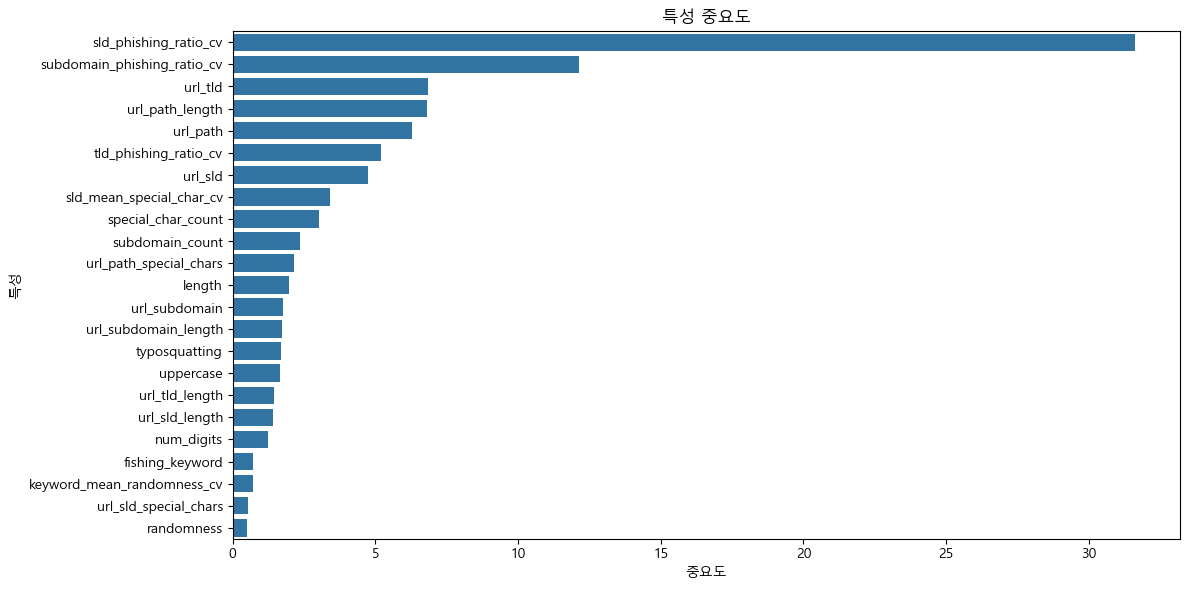

In [45]:
# 특성 중요도 시각화
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': models[0].feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('특성 중요도')
plt.xlabel('중요도')
plt.ylabel('특성')
plt.tight_layout()
plt.show()

## 6. K-Fold Ensemble Inference (K-Fold 앙상블 추론)

In [46]:
test_probabilities = np.zeros(len(X_test))

for model in models:
    test_probabilities += model.predict_proba(X_test)[:, 1]

test_probabilities /= len(models)
print('Inference Done.')

Inference Done.


## 7. Submission (제출 파일 생성)

In [47]:
test_df['probability'] = test_probabilities
test_df[['ID', 'probability']].to_csv('./submission.csv', index=False)
print('Done.')

Done.
